# APS Failure at Scania Trucks

## Introduction

-The dataset consists of data collected from heavy Scania
trucks in everyday usage. The system in focus is the
Air Pressure system (APS) which generates pressurised
air that are utilized in various functions in a truck,
such as braking and gear changes. The datasets'
positive class consists of component failures
for a specific component of the APS system.
The negative class consists of trucks with failures
for components not related to the APS. The data consists
of a subset of all available data, selected by experts.

-Challenge metric


Cost-metric of miss-classification:

Predicted class | True class |
| pos | neg |
-----------------------------------------
pos | - | Cost_1 |
-----------------------------------------
neg | Cost_2 | - |
-----------------------------------------
Cost_1 = 10 and cost_2 = 500

The total cost of a prediction model the sum of 'Cost_1'
multiplied by the number of Instances with type 1 failure
and 'Cost_2' with the number of instances with type 2 failure,
resulting in a 'Total_cost'.

In this case Cost_1 refers to the cost that an unnessecary
check needs to be done by an mechanic at an workshop, while
Cost_2 refer to the cost of missing a faulty truck,
which may cause a breakdown.

Total_cost = Cost_1*No_Instances + Cost_2*No_Instances. 


- The training set contains 60000 examples in total in which
59000 belong to the negative class and 1000 positive class.
The test set contains 16000 examples.

-  Number of Attributes: 171 

-  Attribute Information:
The attribute names of the data have been anonymized for
proprietary reasons. It consists of both single numerical
counters and histograms consisting of bins with different
conditions. Typically the histograms have open-ended
conditions at each end. For example if we measuring
the ambient temperature 'T' then the histogram could
be defined with 4 bins where:
- bin 1 collect values for temperature T < -20
- bin 2 collect values for temperature T >= -20 and T < 0
- bin 3 collect values for temperature T >= 0 and T < 20
- bin 4 collect values for temperature T > 20


In [39]:
# importing all the necessary libraries
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from tqdm import tqdm 
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer,MissingIndicator
from sklearn.decomposition import TruncatedSVD
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn.metrics import confusion_matrix,f1_score,log_loss
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import missingno as msno
from sklearn.decomposition import PCA
from datetime import datetime
from pyod.models.auto_encoder import AutoEncoder
from pyod.models.feature_bagging import FeatureBagging
from fancyimpute import SoftImpute
from impyute.imputation.cs import mice

# 1. Reading the Train and the Test file

In [40]:
train = pd.read_csv('aps_failure_training_set.csv')

In [41]:
train.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,76698,na,2130706438,280,0,0,0,0,0,...,1240520,493384,721044,469792,339156,157956,73224,0,0,0
1,neg,33058,na,0,na,0,0,0,0,0,...,421400,178064,293306,245416,133654,81140,97576,1500,0,0
2,neg,41040,na,228,100,0,0,0,0,0,...,277378,159812,423992,409564,320746,158022,95128,514,0,0
3,neg,12,0,70,66,0,10,0,0,0,...,240,46,58,44,10,0,0,0,4,32
4,neg,60874,na,1368,458,0,0,0,0,0,...,622012,229790,405298,347188,286954,311560,433954,1218,0,0


In [42]:
print('Number of data points in the train dataset', train.shape[0])
print('Number of features in the given train dataset', train.shape[1])

Number of data points in the train dataset 60000
Number of features in the given train dataset 171


In [43]:
test = pd.read_csv('aps_failure_test_set.csv')

In [44]:
test.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,60,0,20,12,0,0,0,0,0,...,1098,138,412,654,78,88,0,0,0,0
1,neg,82,0,68,40,0,0,0,0,0,...,1068,276,1620,116,86,462,0,0,0,0
2,neg,66002,2,212,112,0,0,0,0,0,...,495076,380368,440134,269556,1315022,153680,516,0,0,0
3,neg,59816,na,1010,936,0,0,0,0,0,...,540820,243270,483302,485332,431376,210074,281662,3232,0,0
4,neg,1814,na,156,140,0,0,0,0,0,...,7646,4144,18466,49782,3176,482,76,0,0,0


In [45]:
print('Number of data points in the test dataset', test.shape[0])
print('Number of features in the given test dataset', test.shape[1])

Number of data points in the test dataset 16000
Number of features in the given test dataset 171


# 2. EDA on the Train Dataset

In [46]:
# Replacing all the class labels as follows:

# neg = 0
# pos = 1
class_labels_train = []
for x in tqdm(train.index):
    if train['class'].loc[x] == 'neg':
        class_labels_train.append(0)
        
    else:
        class_labels_train.append(1)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60000/60000 [00:01<00:00, 38914.17it/s]


In [47]:
train['class'] = class_labels_train

In [48]:
train.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,0,76698,na,2130706438,280,0,0,0,0,0,...,1240520,493384,721044,469792,339156,157956,73224,0,0,0
1,0,33058,na,0,na,0,0,0,0,0,...,421400,178064,293306,245416,133654,81140,97576,1500,0,0
2,0,41040,na,228,100,0,0,0,0,0,...,277378,159812,423992,409564,320746,158022,95128,514,0,0
3,0,12,0,70,66,0,10,0,0,0,...,240,46,58,44,10,0,0,0,4,32
4,0,60874,na,1368,458,0,0,0,0,0,...,622012,229790,405298,347188,286954,311560,433954,1218,0,0


In [49]:
# Distrubution of class labels in train dataset
train['class'].value_counts()

0    59000
1     1000
Name: class, dtype: int64

Text(0.5,1,'Histogram plot of class labels')

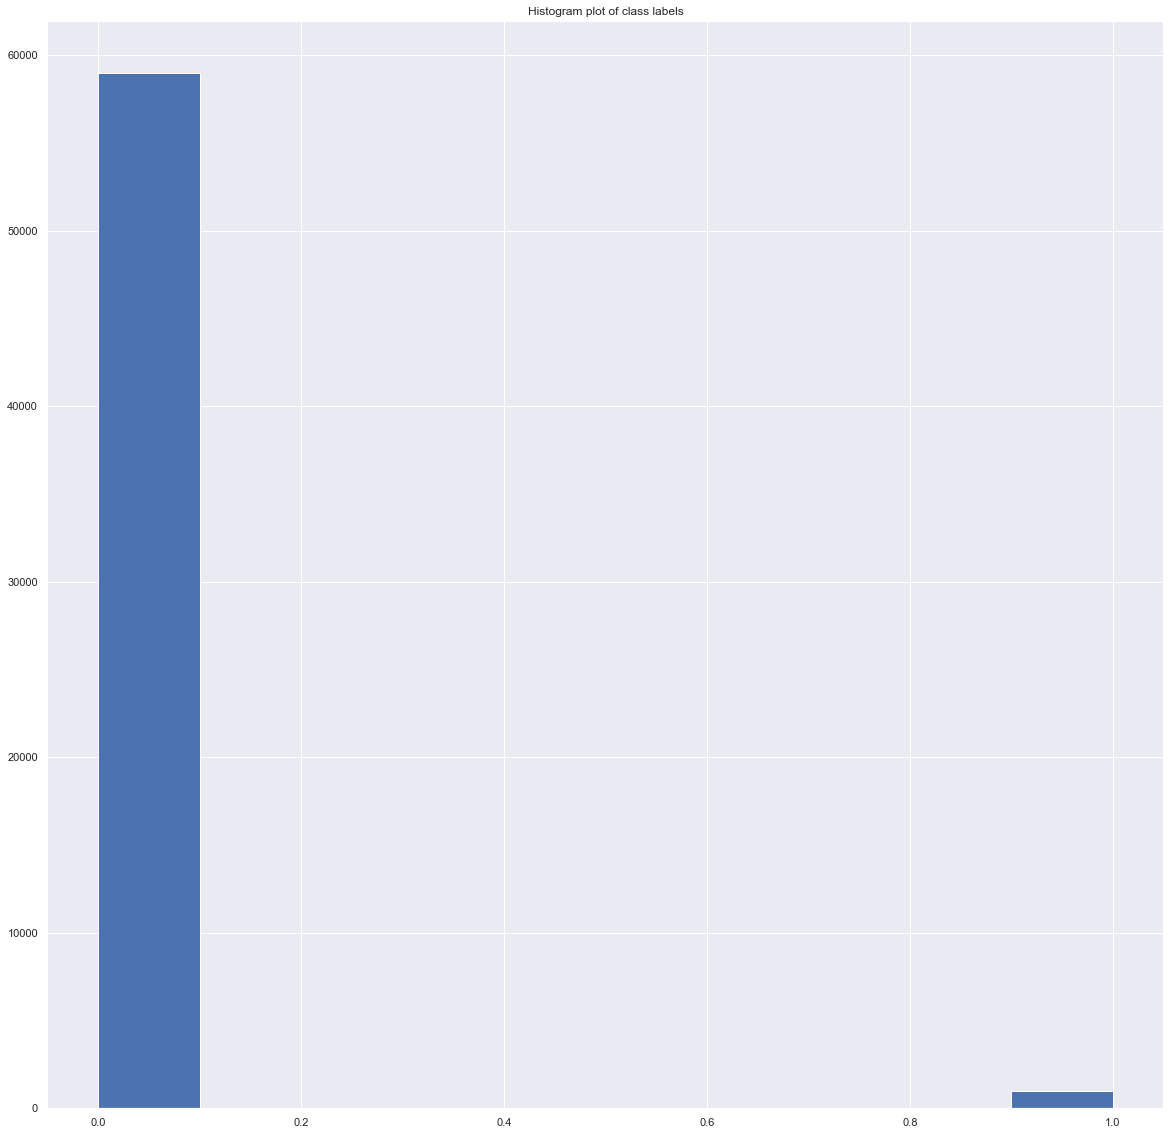

In [50]:
# Histogram plot of class labels of train dataset
plt.hist(train['class'])
plt.title("Histogram plot of class labels")

In [51]:
print("Percentage of negative class in the given dataset :", (train[train['class']== 0].shape[0] / train.shape[0]) * 100)
print("Percentage of positive class in the given dataset :", (train[train['class']== 1].shape[0] / train.shape[0]) * 100)

Percentage of negative class in the given dataset : 98.33333333333333
Percentage of positive class in the given dataset : 1.6666666666666667


# Observations:

- From the above plot, the given dataset is highly imbalanced. Negative class dominates over the positive class.

In [52]:
y_train = train['class']
train.drop(['class'],axis = 1,inplace = True)

In [53]:
train.describe(include='all')

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
count,6.000000e+04,60000,60000,60000,60000,60000,60000,60000,60000,60000,...,60000,60000,60000,60000,60000,60000,60000,60000,60000,60000
unique,NaN,30,2062,1887,334,419,155,618,2423,7880,...,34489,31712,35189,36289,31796,30470,24214,9725,29,50
top,NaN,na,0,na,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
freq,NaN,46329,8752,14861,55543,55476,59133,58587,56181,46894,...,1364,1557,1797,2814,4458,7898,17280,31863,57021,56794
mean,5.933650e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,1.454301e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,8.340000e+02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,3.077600e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,4.866800e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- Train dataset has lot of Null values.

In [54]:
# Replacing the na and nan values with np.NaN
train.replace(to_replace='nan', value = np.NaN,inplace = True)

train.replace(to_replace = 'na', value = np.NaN, inplace = True)

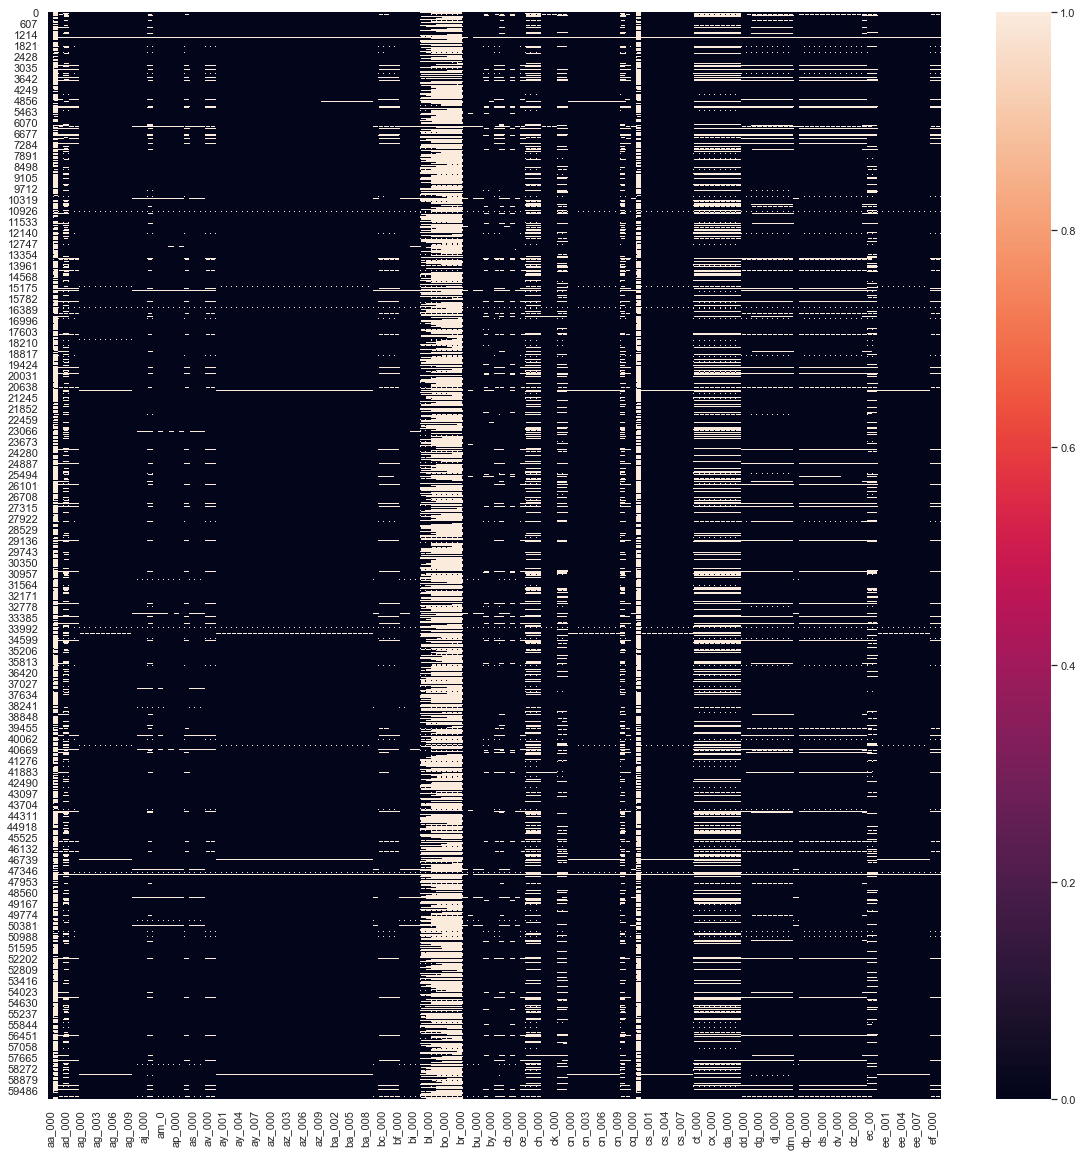

In [56]:
# plotting the heatmap of train dataset to visualize the null values.
sns.set(rc={'figure.figsize':(20,20)})
plot = sns.heatmap(train.isnull())
plt.show(plot)

In [57]:
columns_names = train.columns

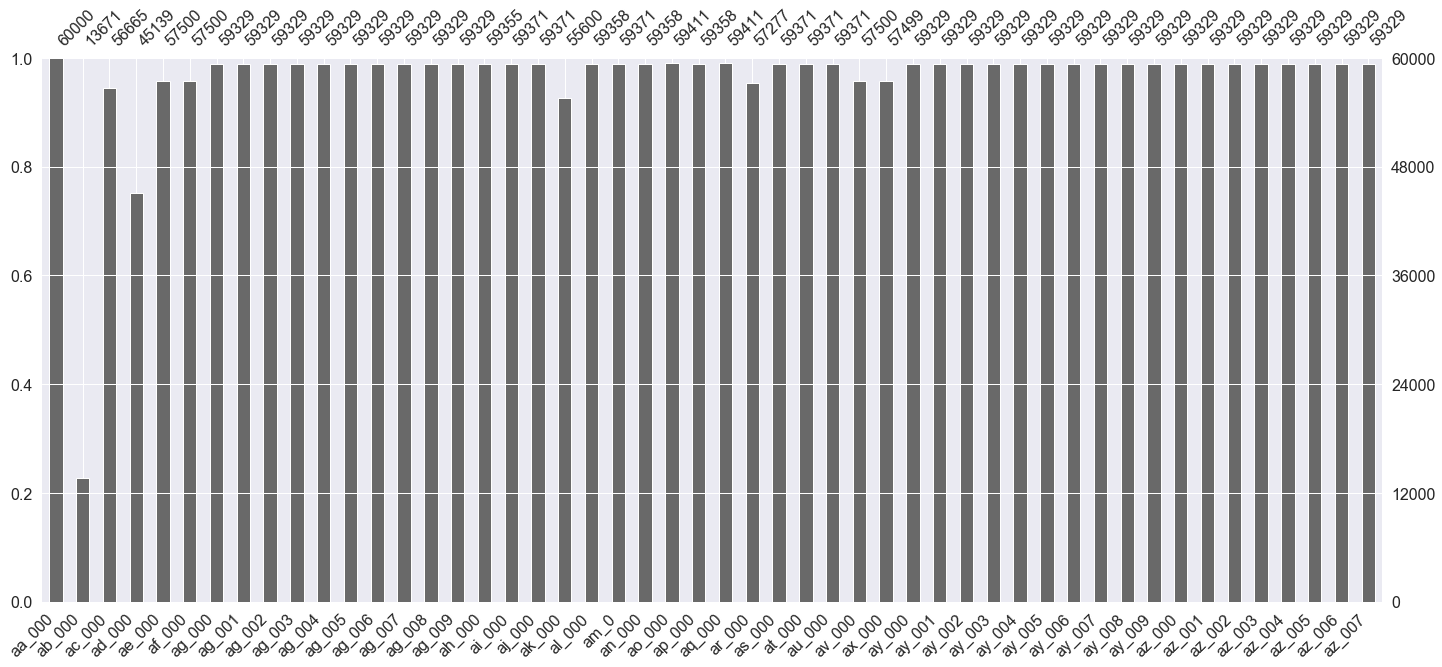

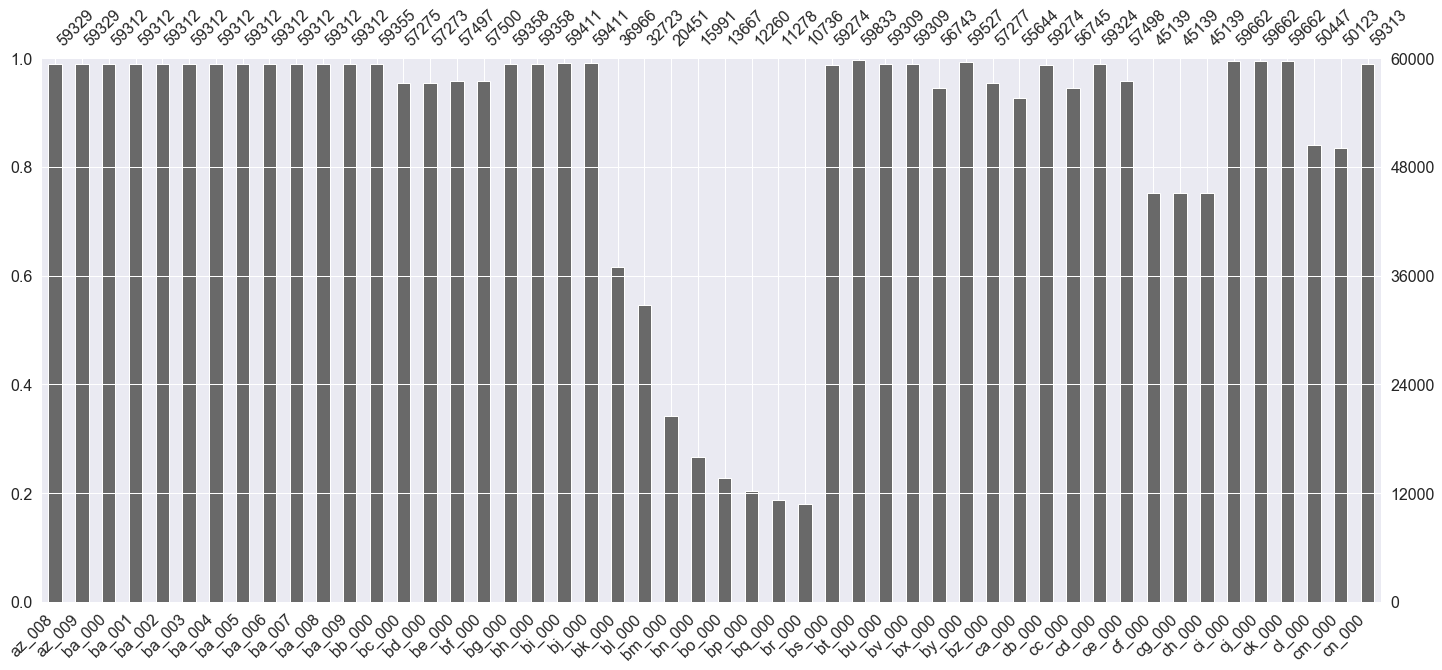

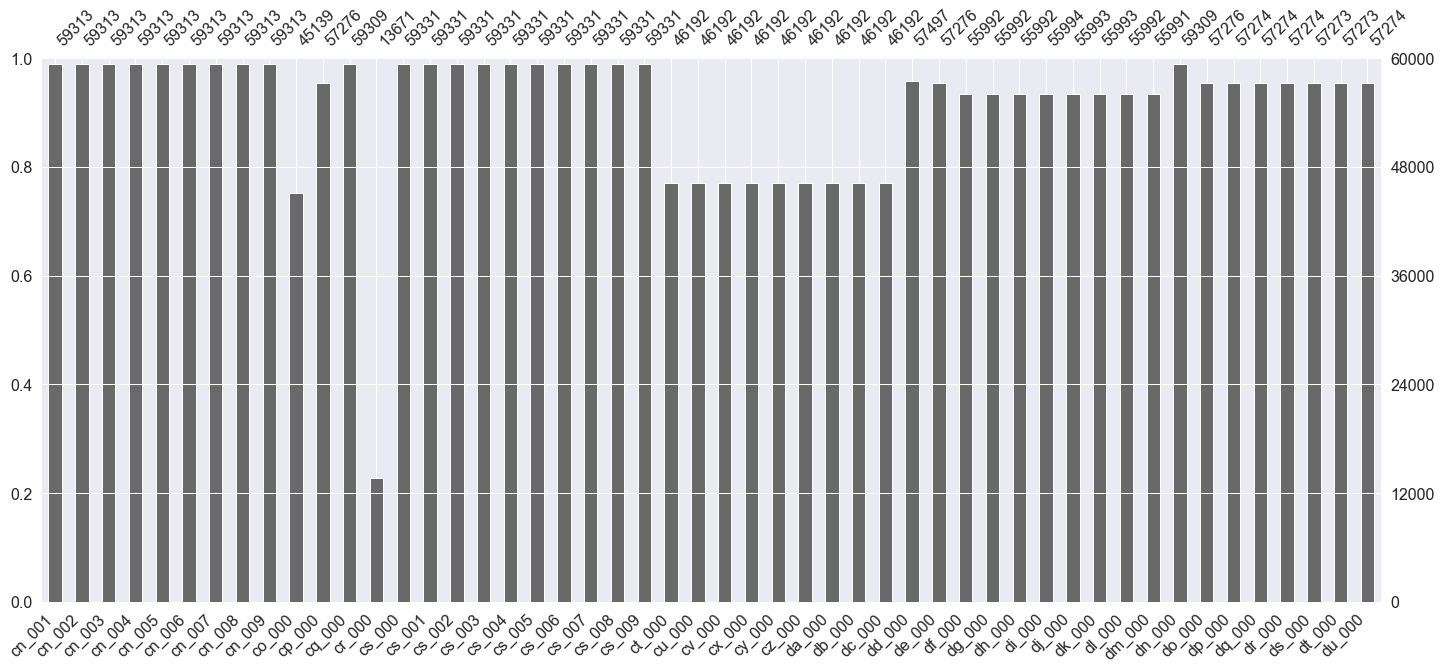

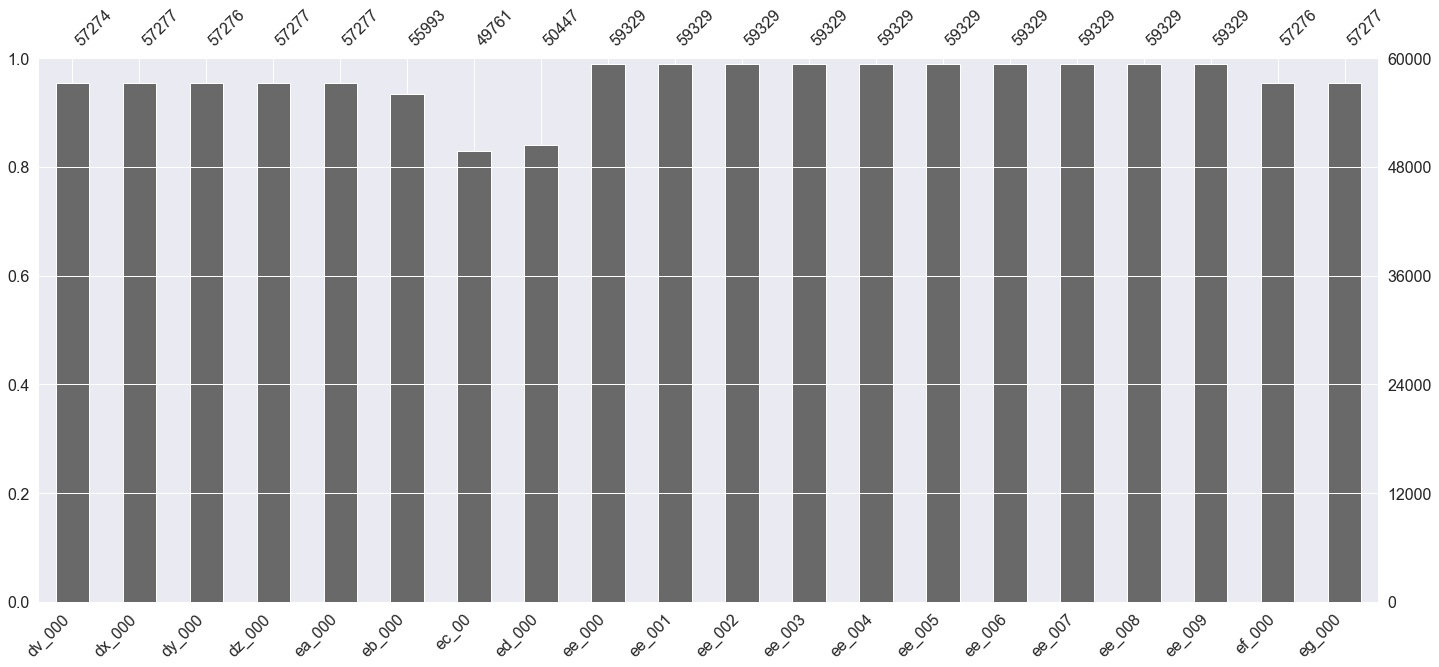

In [58]:
# Plot to indicate the number of missing values in each column of the dataset.
msno.bar(train[columns_names[0:50]])
msno.bar(train[columns_names[50:100]])
msno.bar(train[columns_names[100:150]])
msno.bar(train[columns_names[150:171]])

# Removing all the columns where missing values are more than 70%

- Total number of rows = 60k
- removing all the columns where more than 70% missing values are present = 60000 x 0.7 = 42000

In [59]:
# Dropping all the columns where the number of missing values are more than 42K
train.dropna(axis = 1, thresh=42000,inplace= True)

In [83]:
train.head()

,aa_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,...,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000,class
0,76698,2130706438,280,0,0,0,0,0,0,37250,...,493384,721044,469792,339156,157956,73224,0,0,0,0
1,33058,0,NaN,0,0,0,0,0,0,18254,...,178064,293306,245416,133654,81140,97576,1500,0,0,0
2,41040,228,100,0,0,0,0,0,0,1648,...,159812,423992,409564,320746,158022,95128,514,0,0,0
3,12,70,66,0,10,0,0,0,318,2212,...,46,58,44,10,0,0,0,4,32,0
4,60874,1368,458,0,0,0,0,0,0,43752,...,229790,405298,347188,286954,311560,433954,1218,0,0,0


- After removing all the columns with missing values more than 42k, we now have 160 columns.
- The number of missing values in these 160 columns are less than 70%.
- Different Imputation techniques are used to replace all the missing values.

## Imputation Techniques used

- 1) Median
- 2) Mean
- 3) Most frequent

## Imputing all the missing values

In [87]:
# Imputation using median
impute_median = SimpleImputer(missing_values= np.nan, strategy='median',copy = True, verbose= 2)
train_imputed_median = pd.DataFrame(impute_median.fit_transform(train),columns=train.columns)
train_imputed_median.to_csv("Train_imputed_median")

In [88]:
# Imputation using mean
impute_mean = SimpleImputer(missing_values= np.nan, strategy='mean',copy = True, verbose= 2)
train_imputed_mean = pd.DataFrame(impute_mean.fit_transform(train),columns=train.columns)
train_imputed_mean.to_csv("Train_imputed_mean")

In [89]:
# Imputation using most frequent
impute_most_frequent = SimpleImputer(missing_values= np.nan, strategy='most_frequent',copy = True, verbose= 2)
train_imputed_most_frequent = pd.DataFrame(impute_most_frequent.fit_transform(train),columns=train.columns)
train_imputed_most_frequent.to_csv("Train_imputed_most_frequent")

In [105]:
# Feature engineering, creating a new feature set which indicates the missing value in a given row and column as True else False
missing_impute = MissingIndicator()
miss = missing_impute.fit_transform(train)
train_miss_indi = pd.DataFrame(miss)
train_miss_indi.to_csv('train_miss_indi.csv')

# 3)  EDA on Test Data

In [91]:
y_test = test['class']
test.drop(['class'],axis =1, inplace= True)

In [92]:
y_test.value_counts()

0    15625
1      375
Name: class, dtype: int64

### Observations: Test dataset is highly imbalanced

In [93]:
# Replacing all the class labels as follows:

# neg = 0
# pos = 1
class_labels_test = []
for x in tqdm(y_test.index):
    if y_test.loc[x] == 'neg':
        class_labels_test.append(0)
        
    else:
        class_labels_test.append(1)

y_test = class_labels_test

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16000/16000 [00:01<00:00, 12985.39it/s]


In [94]:
test = test[train.columns]
test.head()

,aa_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,60,20,12,0,0,0,0,0,2682,4736,...,1098,138,412,654,78,88,0,0,0,0
1,82,68,40,0,0,0,0,0,0,748,...,1068,276,1620,116,86,462,0,0,0,0
2,66002,212,112,0,0,0,0,0,199486,1358536,...,495076,380368,440134,269556,1315022,153680,516,0,0,0
3,59816,1010,936,0,0,0,0,0,0,123922,...,540820,243270,483302,485332,431376,210074,281662,3232,0,0
4,1814,156,140,0,0,0,0,0,0,72,...,7646,4144,18466,49782,3176,482,76,0,0,0


In [95]:
test.describe(include='all')

,aa_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
count,1.600000e+04,15074,12019,15310,15310,15811,15811,15811,15811,15811,...,15808,15808,15808,15808,15808,15808,15808,15808,15238,15238
unique,NaN,1311,1202,170,201,59,221,800,2835,8647,...,11937,11038,11817,11915,10831,10271,8314,4042,12,24
top,NaN,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
freq,NaN,2289,519,14764,14741,15749,15575,14954,12442,340,...,356,406,469,735,1151,2061,4500,8432,15167,15107
mean,6.799698e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,5.035350e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,9.280000e+02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,3.098200e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,4.947900e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [96]:
test.replace(to_replace=['na','nan'],value = np.NaN,inplace=True)

In [97]:
test.describe(include='all')

,aa_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
count,1.600000e+04,15074,12019,15310,15310,15811,15811,15811,15811,15811,...,15808,15808,15808,15808,15808,15808,15808,15808,15238,15238
unique,NaN,1311,1202,170,201,59,221,800,2835,8647,...,11937,11038,11817,11915,10831,10271,8314,4042,12,24
top,NaN,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
freq,NaN,2289,519,14764,14741,15749,15575,14954,12442,340,...,356,406,469,735,1151,2061,4500,8432,15167,15107
mean,6.799698e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,5.035350e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,9.280000e+02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,3.098200e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,4.947900e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [98]:
# Median Imputation
test_imputed_median = pd.DataFrame(impute_median.transform(test),columns=train.columns)
test_imputed_median.to_csv("test_imputed_median")

In [99]:
# Mean Imputation
test_imputed_mean = pd.DataFrame(impute_mean.transform(test),columns=train.columns)
test_imputed_mean.to_csv("test_imputed_mean")

In [100]:
# Most Frequent Imputation
test_imputed_most_frequent = pd.DataFrame(impute_most_frequent.transform(test),columns=train.columns)
test_imputed_most_frequent.to_csv("test_imputed_most_frequent")

In [104]:
# missing value indicator feature set.
miss = missing_impute.transform(test)
test_miss_indi = pd.DataFrame(miss)
test_miss_indi.to_csv('test_miss_indi.csv')

In [107]:
y_train.to_csv('y_train.csv')
y_test = pd.DataFrame(y_test)
y_test.to_csv('y_test.csv')

##### Refer aps_model for ML modeling